In [97]:
sx=3884

sy =10846

In [98]:
import os.path as osp
import GPUtil
import torch.nn as nn
import torch
from focal_loss.focal_loss import FocalLoss

from torch.nn import TransformerEncoder, TransformerEncoderLayer
import os
from torch_geometric.data import Dataset, download_url
from torch_geometric.loader import DataLoader
import pandas as pd
from performance import performances_val
from PIL import Image
from torch.nn import Linear
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, global_max_pool
from torch_geometric.nn.norm import BatchNorm
from torch_geometric.data import Data
from sklearn import metrics
import numpy as np
from tqdm import tqdm
from torch_geometric.nn import ChebConv, GraphSAGE,GraphUNet ,TransformerConv

# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
seed = 1378
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
landmark_colors = np.load("landmark_colors.npy")
from sklearn.preprocessing import OneHotEncoder
one_hot_list=[]
enc = OneHotEncoder()
enc.fit(np.expand_dims(landmark_colors,axis=1))  
for x in landmark_colors:
    one_hot_list.append(enc.transform([[x]]).toarray()[0])
one_hot_arr  = np.array(one_hot_list)
one_hot_arr = torch.FloatTensor(one_hot_arr)

m = torch.nn.Softmax(dim=-1)

class landmark_dataset(Dataset):
    def __init__(self, info_list, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(None, transform, pre_transform, pre_filter)
        
        self.graphs = pd.read_csv(info_list, delimiter=",", header=None)


    def len(self):
        return len(self.graphs)

    def get(self, idx):
        
        graph_path = self.graphs.iloc[sx]
        graph_path = graph_path[0]
        print(graph_path)
        
        
        data = torch.load(graph_path)
        #data.x =data.x.t()
        return data 
class landmark_dataset_train(Dataset):
    def __init__(self, info_list, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(None, transform, pre_transform, pre_filter)
        
        self.graphs = pd.read_csv(info_list, delimiter=",", header=None)


    def len(self):
        return len(self.graphs)

    def get(self, idx):
        
        graph_path = self.graphs.iloc[sy]
        graph_path = graph_path[0]
        print(graph_path)
        
        data = torch.load(graph_path)
        
 
        
        domain_name = graph_path.split("/")[-4]
        
            
        if domain_name == "MSU_MFSD" :
            
            domain_label = 0
            
        elif domain_name == "Replay_attack_dataset" :
            
            domain_label = 1
            
        elif domain_name == "oulu" :
            
            domain_label = 2
        else :
            print(graph_path,domain_name )
            raise "error"
            
        #print(data.y)
        data = Data(x=data.x, edge_index=data.edge_index,y =data.y,data = domain_label,y_node = one_hot_arr)

        #data.x =data.x.t()
        return data 
train_dataset = landmark_dataset_train("/home/hassan-hossein/single_image_graph_face_anti_spoofing/train/graph_train_O_M_I.txt")
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,num_workers=16,pin_memory=True)

test_dataset = landmark_dataset("/home/hassan-hossein/single_image_graph_face_anti_spoofing/train/graph_test_C.txt")
test_loader = DataLoader(test_dataset, batch_size=64,num_workers=16)
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer

# فرض کنید که داده‌های ورودی شما یک توالی از ۶۸۰ ویژگی دارد.
#sequence_length = 128
#feature_dim = 4  # هر ویژگی تک‌بعدی است

# نمونه داده ورودی (تعداد نمونه‌ها × طول توالی × بعد ویژگی)
#inputs = torch.rand(32, sequence_length, feature_dim)  # 32 نمونه با 680 ویژگی تک‌بعدی

# تعریف یک لایه ترنسفورمر انکودر
class SimpleTransformer(nn.Module):
    def __init__(self, embed_dim, num_layers, nhead,n_out):
        super(SimpleTransformer, self).__init__()
        self.linear = nn.Linear(4, embed_dim)  # افزایش بعد ویژگی‌ها
        self.encoder_layer = TransformerEncoderLayer(d_model=embed_dim, nhead=nhead)
        self.transformer_encoder = TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(128 * embed_dim, n_out)  # فرضا 10 کلاس خروجی داریم

    def forward(self, x):
        x = self.linear(x)  # تغییر بعد ویژگی‌ها
        x = self.transformer_encoder(x)
        x = x.view(x.size(0), -1)  # فشرده‌سازی به یک بردار برای طبقه‌بندی
        x = self.fc(x)
        return x

# # ایجاد مدل و ارسال ورودی
# # model = SimpleTransformer(embed_dim=embed_dim, num_layers=2, nhead=4)
# # output = model(inputs)

# #print(output.shape)
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer

# فرض کنید که داده‌های ورودی شما یک توالی از ۶۸۰ ویژگی دارد.
sequence_length = 128
feature_dim = 1  # هر ویژگی تک‌بعدی است

# نمونه داده ورودی (تعداد نمونه‌ها × طول توالی × بعد ویژگی)
#inputs = torch.rand(32, sequence_length, feature_dim)  # 32 نمونه با 680 ویژگی تک‌بعدی

# تعریف یک لایه ترنسفورمر انکودر
class SimpleTransformer_2(nn.Module):
    def __init__(self, embed_dim, num_layers, nhead):
        super(SimpleTransformer_2, self).__init__()
        self.linear = nn.Linear(feature_dim, embed_dim)  # افزایش بعد ویژگی‌ها
        self.encoder_layer = TransformerEncoderLayer(d_model=embed_dim, nhead=nhead)
        self.transformer_encoder = TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(sequence_length * embed_dim, 7)  # فرضا 10 کلاس خروجی داریم

    def forward(self, x):
        x = self.linear(x)  # تغییر بعد ویژگی‌ها
        x = self.transformer_encoder(x)
        x = x.view(x.size(0), -1)  # فشرده‌سازی به یک بردار برای طبقه‌بندی
        x = self.fc(x)
        return x

# # ایجاد مدل و ارسال ورودی
# # model = SimpleTransformer(embed_dim=embed_dim, num_layers=2, nhead=4)
# # output = model(inputs)

# #print(output.shape)


In [99]:
class RandomNodeDropout(nn.Module):
    def __init__(self, drop_prob=0.3):
        super(RandomNodeDropout, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x, enabled=True):
        if not self.training or not enabled:
            return x
        
        num_rows = x.size(0)
        mask = torch.rand(num_rows, device=x.device) > self.drop_prob
        mask = mask.float().unsqueeze(1).expand_as(x)
        x = x * mask
        
        return x

soft = torch.nn.Softmax(dim=1)

num_domain = 3
class GRL(nn.Module):

    def __init__(self, max_iter):
        super(GRL, self).__init__()
        self.iter_num = 0
        self.alpha = 10
        self.low = 0.0
        self.high = 1.0
        self.max_iter = max_iter

    def forward(self, input):
        self.iter_num += 1
        return input * 1.0

    def backward(self, gradOutput):
        coeff = np.float(2.0 * (self.high - self.low) / (1.0 + np.exp(-self.alpha * self.iter_num / self.max_iter))
                         - (self.high - self.low) + self.low)
        return -coeff*10* gradOutput

num_node  =train_dataset.num_node_features
class Discriminator(torch.nn.Module):
    def __init__(self,hidden_channels ,max_iter):
        super(Discriminator, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        self.conv2 = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        self.conv3 = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        self.conv4 = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        self.drop_1 = RandomNodeDropout(drop_prob=0.3)
        self.drop_2 = RandomNodeDropout(drop_prob=0.3)
        self.grl_layer = GRL(max_iter)
        self.fc2 = nn.Linear(hidden_channels, num_domain)
        
    def forward(self, x, edge_index, batch,drop_en):
        #print("graph fea :",graph_level_feature.shape ,edge_index.shape )
        
        x = self.grl_layer(x)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.drop_1(x,drop_en)
        
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.drop_2(x,drop_en)
        
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        x = x.relu()
        
        x = global_mean_pool(x, batch)
        
        x = self.fc2(x)
        x = m(x)
         
        return x 



class GCN(torch.nn.Module):
    def __init__(self, hidden_channels,max_iter=4000):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = ChebConv(num_node, hidden_channels,2)
        self.conv2 = ChebConv(hidden_channels, hidden_channels,2)
        self.conv3 = ChebConv(hidden_channels, hidden_channels,2)
        self.conv4 = ChebConv(hidden_channels, hidden_channels,2)
        self.conv5 = ChebConv(hidden_channels*2, hidden_channels,2)
        self.conv6 = ChebConv(hidden_channels, hidden_channels,2)
        self.conv7 = ChebConv(hidden_channels, hidden_channels,2)
        self.conv8 = ChebConv(hidden_channels, hidden_channels,2)
        self.lin = SimpleTransformer(8,5,8,1)
        
        self.drop_1 = RandomNodeDropout(drop_prob=0.3)
        self.drop_2 = RandomNodeDropout(drop_prob=0.3)
        self.drop_3 = RandomNodeDropout(drop_prob=0.3)
        self.drop_4 = RandomNodeDropout(drop_prob=0.3)
        self.drop_5 = RandomNodeDropout(drop_prob=0.3)
        self.drop_6 = RandomNodeDropout(drop_prob=0.3)
        
        
        self.b1 = BatchNorm(hidden_channels)
        self.b2 = BatchNorm(hidden_channels)
        self.b3 = BatchNorm(hidden_channels)
        self.b4 = BatchNorm(hidden_channels)
        self.b5 = BatchNorm(hidden_channels)
        self.b6 = BatchNorm(hidden_channels)
        self.b7 = BatchNorm(hidden_channels)
        
        self.dis = Discriminator(hidden_channels,max_iter)
        
        self.conv1_node_class = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        
        self.conv2_node_class = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        
        self.lin_node_class = SimpleTransformer_2(64,10,8)
        

        
        #self.tcn = Simple1DCNN()
        
    def forward(self, x, edge_index, batch,drop_en,index_arr):
        #print("graph fea :",graph_level_feature.shape ,edge_index.shape )
        

        x = self.conv1(x, edge_index)
        x  = self.b1(x)
        x = x.relu()
        
        x = self.drop_1(x,drop_en)
        
        

        x = self.conv2(x, edge_index)
        x  = self.b2(x)
        x = x.relu()
        
        x = self.drop_2(x,drop_en)
                
        dicriminator = x
        
        x_1 = global_mean_pool(x, batch)
        
        x = self.conv3(x, edge_index)
        x  = self.b3(x)
        x = x.relu()
        
        x = self.drop_3(x,drop_en)
        
        x_3 = global_mean_pool(x, batch)
        
        
        x = self.conv4(x, edge_index)
        x  = self.b4(x)
        x = x.relu()
        
        x = self.drop_4(x,drop_en)
        
        
        x = torch.cat((x,dicriminator),dim=1) #skip connection
        
        x = self.conv5(x, edge_index)
        x  = self.b5(x)
        x = x.relu()
        
        x = self.drop_5(x,drop_en)
        
        x_5 = global_mean_pool(x, batch)
        
        x = self.conv6(x, edge_index)
        x  = self.b6(x)
        x = x.relu()
        
        x = self.drop_6(x,drop_en)
        
        x = self.conv7(x, edge_index)
        x  = self.b7(x)
        x = x.relu()
        
        
        x = self.conv8(x, edge_index)
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        
        x = torch.stack([x,x_1,x_5,x_3],dim=2)
        
        x = F.dropout(x, p=0.5, training=self.training)
        
        #x = torch.unsqueeze(x,2)
        #print(x.shape)
        
        x = self.lin(x)
        
        x= x.sigmoid()
        
        
        node_class_hidden = self.conv1_node_class(dicriminator,edge_index)
        node_class_hidden = node_class_hidden.relu()
        
        node_class_hidden = self.conv2_node_class(node_class_hidden,edge_index)
        node_class_hidden = node_class_hidden.relu()
        
        #print(index_arr.shape , node_class_hidden.shape)
        
        node_class_hidden = node_class_hidden[index_arr]
        
        #print(node_class_hidden.shape)
        node_class_hidden = torch.unsqueeze(node_class_hidden, dim=2)
        
        node_pre = self.lin_node_class(node_class_hidden)
        
            
        #print("hiiii :" , dicriminator.shape)
        dis_invariant = self.dis(dicriminator,edge_index,batch,drop_en)
        
        return x ,dis_invariant ,node_pre

model = GCN(hidden_channels=128).to(device)
print(model)

def check_folder(log_dir):
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    return log_dir

optimizer = torch.optim.Adam(model.parameters(), lr=0.000000001)
#criterion = torch.nn.CrossEntropyLoss()
criterion= nn.BCELoss()
criterion_node_class=  torch.nn.CrossEntropyLoss()
criterion_2 = FocalLoss(gamma=2)
def train(epoch):
    model.train()
    losses_adv_loss=0
    losses_loss_cls=0
    total_loss = 0
    losses_node_cls_loss = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}', unit='batch')
    for graph in progress_bar:  # Iterate in batches over the training dataset.
        graph = graph.to(device)  # Move data to the device
        
        drop_en = bool(np.random.binomial(1, 0.5))
        
        if graph.x.shape[0] < 29952 :
            
            if graph.x.shape[0] < 64:
            
                index_arr = torch.randint(0, int(graph.x.shape[0]), (int(graph.x.shape[0]),)).to(device)
            else :
                
                index_arr = torch.randint(0, int(graph.x.shape[0]), (64,)).to(device)
        else :
                
            index_arr = torch.randint(0, 29952, (64,)).to(device)
        
        
        
        out,domain_invariant,node_pre = model(graph.x, graph.edge_index, graph.batch,drop_en,index_arr)  # Perform a single forward pass.
        
        adv_loss = criterion_2(domain_invariant, graph.data)
        
        node_cls_loss = criterion_node_class(node_pre.squeeze(),graph.y_node.float()[index_arr])
        #print(out.shape , graph.y.long().shape)
        loss_cls = criterion(out.squeeze(), graph.y.float())  # Compute the loss.
        
        loss_all = adv_loss + loss_cls + node_cls_loss
        loss_all.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        total_loss = loss_all + total_loss
        losses_adv_loss = adv_loss + losses_adv_loss
        losses_loss_cls = loss_cls + losses_loss_cls
        losses_node_cls_loss = node_cls_loss + losses_node_cls_loss


    print("/////////////////////////")
    print("adverserial loss : " ,losses_adv_loss/len(train_loader.dataset))  
    print("classification loss : " , losses_loss_cls/len(train_loader.dataset))
    print("classification node loss : " , losses_node_cls_loss/len(train_loader.dataset))
    print("total loss : " ,total_loss/len(train_loader.dataset) )
    print("////////////////////////////////////")
def test(loader,epoch):
    score_path = os.path.join("/home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores", "epoch_{}".format(epoch+1))
    check_folder(score_path)
    model.eval()
    with torch.no_grad():
        scores_list = []

        correct = 0
        s= 0
        progress_bar = tqdm(loader, desc=f'Epoch {epoch+1}', unit='batch')
        for graph in progress_bar:  # Iterate in batches over the training/test dataset.
            if graph.x.shape[0] < 29952 :

                if graph.x.shape[0] < 64:

                    index_arr = torch.randint(0, int(graph.x.shape[0]), (int(graph.x.shape[0]),)).to(device)
                else :

                    index_arr = torch.randint(0, int(graph.x.shape[0]), (64,)).to(device)
            else :

                index_arr = torch.randint(0, 29952, (64,)).to(device)
                
            graph = graph.to(device)  # Move data to the device
            logit,_ ,_= model(graph.x, graph.edge_index, graph.batch,False,index_arr)
            live_label = graph.y.float()
            print(live_label,logit)
            for i in range(len(logit)):
                        scores_list.append("{} {}\n".format(logit[i].item(), live_label[i].item()))
  # Check against ground-truth labels.
    map_score_val_filename = os.path.join(score_path, "score.txt")
    with open(map_score_val_filename, 'w') as file:
                file.writelines(scores_list)
    print("score: write test scores to {}".format(map_score_val_filename))
    test_ACC, fpr, FRR, HTER, auc_test, test_err, tpr = performances_val(map_score_val_filename)
    print("epoch:{:d}, test:  val_ACC={:.4f}, HTER={:.4f}, AUC={:.4f}, val_err={:.4f}, ACC={:.4f}, TPR={:.4f}".format(
        epoch + 1, test_ACC, HTER, auc_test, test_err, test_ACC, tpr))  
    return auc_test




/media/hassan-hossein/B660FEE360FEA8EF/oulu/preposess/oulu_dev_spoof_2_3_29_5/cropped_0085.jpg.pt
GCN(
  (conv1): ChebConv(640, 128, K=2, normalization=sym)
  (conv2): ChebConv(128, 128, K=2, normalization=sym)
  (conv3): ChebConv(128, 128, K=2, normalization=sym)
  (conv4): ChebConv(128, 128, K=2, normalization=sym)
  (conv5): ChebConv(256, 128, K=2, normalization=sym)
  (conv6): ChebConv(128, 128, K=2, normalization=sym)
  (conv7): ChebConv(128, 128, K=2, normalization=sym)
  (conv8): ChebConv(128, 128, K=2, normalization=sym)
  (lin): SimpleTransformer(
    (linear): Linear(in_features=4, out_features=8, bias=True)
    (encoder_layer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
      )
      (linear1): Linear(in_features=8, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=8, bias=True)
  

In [100]:
model.load_state_dict(torch.load("Focal_without_pipline_domain_generalization_tuning.pth",map_location='cuda'))


<All keys matched successfully>

In [101]:

test_dataset = landmark_dataset("/home/hassan-hossein/single_image_graph_face_anti_spoofing/train/graph_test_C.txt")
test_loader = DataLoader(test_dataset, batch_size=1,num_workers=0,shuffle=True)
train_dataset = landmark_dataset_train("/home/hassan-hossein/single_image_graph_face_anti_spoofing/train/graph_train_O_M_I.txt")
train_loader = DataLoader(train_dataset, batch_size=1,num_workers=0)


In [143]:

model.eval()
progress_bar = tqdm(train_loader, desc=f'Epoch {0+1}', unit='batch')

for graph in progress_bar:  # Iterate in batches over the training/test dataset.
    if graph.x.shape[0] < 29952 :

        if graph.x.shape[0] < 64:

            index_arr = torch.randint(0, int(graph.x.shape[0]), (int(graph.x.shape[0]),)).to(device)
        else :

            index_arr = torch.randint(0, int(graph.x.shape[0]), (64,)).to(device)
    else :

        index_arr = torch.randint(0, 29952, (64,)).to(device)

    graph = graph.to(device)  # Move data to the device
    graph.x.requires_grad= True
    logit,_ ,_= model(graph.x, graph.edge_index, graph.batch,False,index_arr)
    
    print(logit)
    model.zero_grad()

    logit.backward()  # محاسبه گرادیان‌ها برای کلاس هدف

    # محاسبه گرادیان‌ها نسبت به ورودی‌ها
    node_gradients = graph.x.grad  # 
    break

    
    


Epoch 1:   0%|                                    | 0/213872 [00:00<?, ?batch/s]

/media/hassan-hossein/B660FEE360FEA8EF/MSU_MSFD_ds/MSU_MFSD/preposess/replay_test_spoof_attack_client001_laptop_SD_ipad_video_scene01/cropped_0055.jpg.pt
tensor([[1.4650e-20]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [137]:
node_gradients

tensor([[ 1.2561e-21, -1.0020e-21, -3.3363e-23,  ...,  5.8742e-22,
          9.1858e-22, -4.2113e-23],
        [-8.4277e-22,  1.4662e-22, -1.4262e-21,  ...,  2.5522e-22,
         -1.7880e-21, -2.9809e-22],
        [-1.7081e-21,  4.4180e-22,  3.6272e-22,  ...,  1.6536e-21,
         -3.1306e-21,  8.2612e-22],
        ...,
        [-2.9670e-22,  1.1966e-21,  1.5464e-21,  ...,  5.3456e-22,
         -1.4635e-21,  1.5467e-21],
        [ 4.5647e-22,  4.3638e-22, -1.3503e-21,  ..., -3.4929e-22,
         -2.9048e-22,  1.0496e-22],
        [-1.2099e-22,  3.9776e-22,  4.9747e-22,  ..., -1.8783e-23,
         -2.2872e-21,  2.5999e-22]], device='cuda:0')

In [69]:
def integrated_gradients(model, graph, baseline=None, steps=50):
    # اگر baseline تعریف نشده باشد، یک تصویر صفر (سیاه) با همان سایز input 
    input = graph.x.requires_grad_(True)
    if baseline is None:
        baseline = torch.zeros_like(input).to(device).requires_grad_(True)
    
    # محاسبه مسیرهای خطی بین baseline و input
    scaled_inputs = [(baseline + (float(i) / steps) * (input - baseline))
                     for i in range(steps + 1)]
    # محاسبه گرادیان‌ها در طول مسیرها
    print(scaled_inputs)
    gradients = []
    for scaled_input in scaled_inputs:
        if graph.x.shape[0] < 29952 :

            if graph.x.shape[0] < 64:

                index_arr = torch.randint(0, int(graph.x.shape[0]), (int(graph.x.shape[0]),)).to(device)
            else :

                index_arr = torch.randint(0, int(graph.x.shape[0]), (64,)).to(device)
        else :

            index_arr = torch.randint(0, 29952, (64,)).to(device)

        graph = graph.to(device)  # Move data to the device
        scaled_input = scaled_input.requires_grad_(True)
        print(scaled_input)
        output,_ ,_= model(scaled_input, graph.edge_index, graph.batch,False,index_arr)
        output.backward(torch.ones_like(output))  #محاسبه گرادیان‌ها
        gradients.append(scaled_input.grad.detach())  # ذخیره گرادیان
    
    # محاسبه میانگین گرادیان‌ها
    avg_gradients = torch.mean(torch.stack(gradients), dim=0)
    
    # محاسبه Integrated Gradients با ضرب میانگین گرادیان‌ها در تفاوت بین input و baseline
    integrated_gradients = (input - baseline) * avg_gradients
    return integrated_gradients

In [17]:
import torch
from tqdm import tqdm

# Set the model to evaluation mode
model.eval()

# Initialize the progress bar for tracking batches in training or testing phase
progress_bar = tqdm(test_loader, desc=f'Epoch {0+1}', unit='batch')

# Iterate over the batches in the dataset
for graph in progress_bar:
    
    # Conditionally set index_arr based on the shape of graph.x
    if graph.x.shape[0] < 29952:
        if graph.x.shape[0] < 64:
            index_arr = torch.randint(0, int(graph.x.shape[0]), (int(graph.x.shape[0]),)).to(device)
        else:
            index_arr = torch.randint(0, int(graph.x.shape[0]), (64,)).to(device)
    else:
        index_arr = torch.randint(0, 29952, (64,)).to(device)

    # Move graph to the device
    graph = graph.to(device)
    steps = 50
    gradients = []
    for i in range(steps + 1) : 
        
        S = (graph.x * (float(i) / steps)).detach().requires_grad_(True)
        # Forward pass through the model
        logit, _, _ = model(S, graph.edge_index, graph.batch, False, index_arr)

        # Print logit for debugging
        print(logit)

        # Zero out the gradients for the model
        model.zero_grad()

        # Backward pass for calculating gradients with respect to the target class
        logit.backward()

        # Retrieve gradients with respect to the input nodes
        node_gradients = S.grad
        #print(node_gradients)
        gradients.append(node_gradients)
    avg_gradients = torch.mean(torch.stack(gradients), dim=0)
    integrated_gradients = (S) * avg_gradients
        # Exit after the first batch for demonstration purposes
    break


Epoch 1:   0%|                                     | 0/22296 [00:00<?, ?batch/s]

/media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_16_HR_3/cropped_0055.jpg.pt
tensor([[1.4117e-18]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1.0796e-18]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[8.3404e-19]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[6.1532e-19]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[4.0647e-19]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[2.5734e-19]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1.7841e-19]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1.3629e-19]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1.1767e-19]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1.0210e-19]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[8.0182e-20]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[6.2177e-20]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[5.1542e-20]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[3.93

Epoch 1:   0%|                                     | 0/22296 [00:01<?, ?batch/s]

tensor([[2.1181e-24]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[2.5446e-23]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[3.7555e-22]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [121]:
node_gradients = integrated_gradients

In [122]:
node_gradients = node_gradients.detach()

In [125]:
node_gradients

tensor([[ 1.7935e-23,  1.2409e-23, -3.4501e-23,  ...,  1.0864e-22,
         -1.5779e-23, -3.5842e-23],
        [ 1.5417e-23, -2.3617e-23, -3.1224e-23,  ...,  9.0985e-23,
         -1.5633e-23, -3.4889e-23],
        [ 1.3165e-22,  2.5305e-25, -7.4697e-23,  ...,  1.3266e-22,
         -3.6406e-23, -6.3923e-23],
        ...,
        [ 1.0671e-22, -2.7922e-23,  4.1390e-23,  ...,  1.0142e-22,
         -1.7684e-23, -5.4719e-23],
        [ 2.8257e-23, -3.7280e-23, -4.7069e-23,  ...,  1.1665e-22,
         -6.2467e-24, -2.4245e-23],
        [ 1.1151e-22, -3.8217e-23, -9.6641e-23,  ...,  1.6892e-22,
         -2.1385e-23, -2.8439e-23]], device='cuda:0')

In [102]:
import networkx as nx
import matplotlib.pyplot as plt
def min_max_scaler(tensor):
    # محاسبه مقادیر کمینه و بیشینه
    min_val = tensor.min()
    max_val = tensor.max()
    
    # چاپ کمینه و بیشینه برای بررسی
    print(f"Min value: {min_val.item()}, Max value: {max_val.item()}")
    
    # اعمال فرمول Min-Max Scaling
    scaled_tensor = (tensor - min_val) / (max_val - min_val + 1e-8)  # اضافه کردن 1e-8 برای جلوگیری از تقسیم بر صفر
    
    # بررسی بزرگترین مقدار بعد از نرمال‌سازی
    print(f"Max scaled value before rescaling: {scaled_tensor.max().item()}")
    
    # استفاده از یک مقیاس پویا بر اساس بزرگترین مقدار
    dynamic_scale_factor = 1 / scaled_tensor.max().item()  # مقیاس پویا برای بزرگترین مقدار
    
    # اعمال مقیاس‌بندی پویا
    scaled_tensor *= dynamic_scale_factor
    
    # بررسی بزرگترین مقدار بعد از مقیاس‌بندی
    print(f"Max scaled value after dynamic rescaling: {scaled_tensor.max().item()}")
    
    return scaled_tensor


def visualize_node_importance_mediapipe(edge_index, node_gradients, threshold=0.1):
    G = nx.Graph()
    
    # اضافه کردن نودها و یال‌ها به گراف
    for i in range(edge_index.size(1)):
        u, v = edge_index[:, i].tolist()
        G.add_edge(u, v)
    
    # محاسبه نرمال گرادیان‌ها به عنوان اهمیت نودها
    node_importance = min_max_scaler(node_gradients.norm(dim=1)).cpu().numpy()
    print(node_importance)
    
    # استفاده از رنگ‌ها و اندازه‌های مختلف برای نودها بر اساس اهمیت
    pos = nx.spring_layout(G)  # تنظیم موقعیت نودها
    
    # رسم نودها
#     plt.figure(figsize=(50,50),dpi=20)

#     nx.draw_networkx_nodes(G, pos, node_size=node_importance , node_color=node_importance, cmap=plt.cm.Reds, alpha=0.9)

#     # رسم یال‌ها
#     nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5)

#     # افزودن برچسب نودها
#     nx.draw_networkx_labels(G, pos, font_size=10, font_color="black")
#     plt.title('Node Importance Visualization (Mediapipe Style)')
#     plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.Reds), label='Importance')
#     plt.show()
#     return node_importance**5
    return node_importance**2

# نمایش گراف با اهمیت نودها
# node_importance = visualize_node_importance_mediapipe(graph.edge_index, node_gradients)


In [103]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

# تنظیمات Mediapipe برای Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True)

def display_face_mesh(image_path, node_sizes):
    # خواندن تصویر
    image = cv2.imread(image_path)
    height, width, _ = image.shape

    # تبدیل تصویر به RGB
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # اعمال فیس مش روی تصویر
    result = face_mesh.process(rgb_image)

    if result.multi_face_landmarks:
        fig, ax = plt.subplots()
        ax.imshow(rgb_image)

        for face_landmarks in result.multi_face_landmarks:
            # استخراج و رسم نودها
            for idx, landmark in enumerate(face_landmarks.landmark):
                # مختصات نودها
                x = int(landmark.x * width)
                y = int(landmark.y * height)

                # گرفتن سایز نود از آرایه node_sizes
                if idx < len(node_sizes):
                    size = node_sizes[idx]
                else:
                    size = 1  # مقدار پیش فرض

                # رسم نودها با سایز متفاوت
                ax.scatter(x, y, s=100, c='red', alpha=size)



        # نمایش تصویر
        plt.axis('off')  # حذف محور‌ها
        plt.show()
        plt.imshow(rgb_image)
        plt.show()

# import cv2
# import matplotlib.pyplot as plt
# import numpy as np
# import mediapipe as mp

# # تنظیم فیس‌مش
# mp_face_mesh = mp.solutions.face_mesh
# face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)

# def display_face_mesh(image_path, node_sizes):
#     # خواندن تصویر
#     image = cv2.imread(image_path)
#     height, width, _ = image.shape

#     # تبدیل تصویر به RGB
#     rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#     # اعمال فیس مش روی تصویر
#     result = face_mesh.process(rgb_image)

#     if result.multi_face_landmarks:
#         fig, ax = plt.subplots()
#         ax.imshow(rgb_image)

#         for face_landmarks in result.multi_face_landmarks:
#             # استخراج و رسم نودها
#             for idx, landmark in enumerate(face_landmarks.landmark):
#                 # مختصات نودها
#                 x = int(landmark.x * width)
#                 y = int(landmark.y * height)

#                 # گرفتن سایز نود از آرایه node_sizes
#                 if idx < len(node_sizes):
#                     size = node_sizes[idx]
#                 else:
#                     size = 1  # مقدار پیش فرض

#                 # تنظیم رنگ و شفافیت بر اساس سایز
#                 color = plt.cm.coolwarm(size*4 / max(node_sizes))  # مقیاس رنگی از آبی به قرمز
#                 #alpha = size / max(node_sizes)  # تنظیم شفافیت بر اساس سایز

#                 # رسم نودها با سایز و رنگ متفاوت
#                 ax.scatter(x, y, s=100, color=color, alpha=0.5)
#         plt.axis('off')  # حذف محور‌ها
#         plt.show()
#         plt.imshow(rgb_image)
#         plt.show()
        
        
        
        
# # مسیر تصویر ورودی و آرایه‌ای از سایز نودها
# image_path = "/media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_train_spoof_13_NM_5/cropped_0075.jpg"

# node_sizes = np.random.randint(1, 5, size=468)  # مثال: سایزهای تصادفی برای هر نود

# # فراخوانی تابع برای نمایش فیس مش و اندازه نودها
# display_face_mesh(image_path, node_importance)



def intergrade_gradient_cam(loader):

    # Set the model to evaluation mode
    model.eval()

    # Initialize the progress bar for tracking batches in training or testing phase
    progress_bar = tqdm(loader, desc=f'Epoch {0+1}', unit='batch')

    # Iterate over the batches in the dataset
    for graph in progress_bar:

        # Conditionally set index_arr based on the shape of graph.x
        if graph.x.shape[0] < 29952:
            if graph.x.shape[0] < 64:
                index_arr = torch.randint(0, int(graph.x.shape[0]), (int(graph.x.shape[0]),)).to(device)
            else:
                index_arr = torch.randint(0, int(graph.x.shape[0]), (64,)).to(device)
        else:
            index_arr = torch.randint(0, 29952, (64,)).to(device)

        # Move graph to the device
        graph = graph.to(device)
        steps = 500
        gradients = []
        for i in range(steps + 1) : 

            S = (graph.x * (float(i) / steps)).detach().requires_grad_(True)
            # Forward pass through the model
            logit, _, _ = model(S, graph.edge_index, graph.batch, False, index_arr)

            # Print logit for debugging
            print(logit)

            # Zero out the gradients for the model
            model.zero_grad()

            # Backward pass for calculating gradients with respect to the target class
            logit.backward()

            # Retrieve gradients with respect to the input nodes
            node_gradients = S.grad
            #print(node_gradients)
            gradients.append(node_gradients)
        avg_gradients = torch.mean(torch.stack(gradients), dim=0)
        integrated_gradients = (S) * avg_gradients
        print(integrated_gradients)
            # Exit after the first batch for demonstration purposes
        
        return integrated_gradients,graph
def explain_with_intergrade(loader,img_path) :
    node_gradients ,graph= intergrade_gradient_cam(loader)
    node_gradients = node_gradients.detach()
    node_importance = visualize_node_importance_mediapipe(graph.edge_index, node_gradients)
    display_face_mesh(img_path, node_importance)
def explain_with_grad_cam(loader,img_path) :
    node_gradients,graph = Grad_cam(loader)
    node_importance = visualize_node_importance_mediapipe(graph.edge_index, node_gradients)
    display_face_mesh(img_path, node_importance)
def Grad_cam(loader) :
    model.eval()
    progress_bar = tqdm(loader, desc=f'Epoch {0+1}', unit='batch')

    for graph in progress_bar:  # Iterate in batches over the training/test dataset.
        if graph.x.shape[0] < 29952 :

            if graph.x.shape[0] < 64:

                index_arr = torch.randint(0, int(graph.x.shape[0]), (int(graph.x.shape[0]),)).to(device)
            else :

                index_arr = torch.randint(0, int(graph.x.shape[0]), (64,)).to(device)
        else :

            index_arr = torch.randint(0, 29952, (64,)).to(device)

        graph = graph.to(device)  # Move data to the device
        graph.x.requires_grad= True
        logit,_ ,_= model(graph.x, graph.edge_index, graph.batch,False,index_arr)

        print(logit)
        model.zero_grad()

        logit.backward()  # محاسبه گرادیان‌ها برای کلاس هدف

        # محاسبه گرادیان‌ها نسبت به ورودی‌ها
        node_gradients = graph.x.grad  # 
        print(node_gradients)
        return node_gradients,graph


Epoch 1:   0%|                                     | 0/22296 [00:00<?, ?batch/s]

/media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_18_HR_4/cropped_0075.jpg.pt
tensor([[1.4117e-18]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1.3679e-18]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1.3262e-18]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1.2861e-18]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1.2476e-18]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1.2106e-18]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1.1751e-18]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1.1408e-18]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1.1077e-18]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1.0755e-18]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1.0444e-18]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1.0142e-18]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[9.8456e-19]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[9.55

tensor([[3.3261e-20]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[3.2880e-20]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[3.2527e-20]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[3.2196e-20]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[3.1873e-20]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[3.1552e-20]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[3.1221e-20]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[3.0877e-20]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[3.0530e-20]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[3.0158e-20]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[2.9754e-20]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[2.9300e-20]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[2.8789e-20]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[2.8212e-20]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[2.7558e-20]], device='cuda:0', grad_fn=

tensor([[3.3907e-21]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[3.4543e-21]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[3.5185e-21]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[3.5822e-21]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[3.6455e-21]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[3.7072e-21]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[3.7676e-21]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[3.8263e-21]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[3.8838e-21]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[3.9394e-21]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[3.9906e-21]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[4.0376e-21]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[4.0782e-21]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[4.1089e-21]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[4.1276e-21]], device='cuda:0', grad_fn=

tensor([[2.0134e-20]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1.9510e-20]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1.8841e-20]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1.8132e-20]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1.7396e-20]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1.6646e-20]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1.5850e-20]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1.5022e-20]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1.4189e-20]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1.3346e-20]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1.2490e-20]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1.1643e-20]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1.0829e-20]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1.0046e-20]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[9.3171e-21]], device='cuda:0', grad_fn=

Epoch 1:   0%|                                     | 0/22296 [00:13<?, ?batch/s]

tensor([[ 4.1603e-23, -8.0275e-25, -1.8793e-23,  ...,  9.9993e-23,
         -1.6199e-23, -2.5713e-23],
        [-2.4857e-23, -1.2673e-23, -3.2102e-23,  ...,  8.3168e-23,
         -1.1972e-23, -2.5290e-23],
        [ 1.0093e-22,  6.1577e-25, -5.3146e-23,  ...,  1.3962e-22,
         -2.6046e-23, -3.7945e-23],
        ...,
        [ 8.7040e-23, -2.0478e-23,  7.8671e-23,  ...,  8.0557e-23,
         -9.4269e-25, -1.5957e-23],
        [ 4.5711e-23, -4.7498e-23, -1.0638e-22,  ...,  9.9290e-23,
         -7.7992e-24, -2.7990e-23],
        [ 1.5208e-22, -6.4220e-23, -1.2671e-22,  ...,  1.5863e-22,
         -1.5031e-23, -3.0696e-23]], device='cuda:0', grad_fn=<MulBackward0>)
Min value: 1.6394177509369196e-21, Max value: 3.509218025218537e-21
Max scaled value before rescaling: 1.8698001588886293e-13
Max scaled value after dynamic rescaling: 0.9999999403953552
[0.22250615 0.26717466 0.73269826 0.31471333 0.7238333  0.2521857
 0.47098008 0.25200814 0.44348863 0.67190737 0.16734232 0.5003979
 0.55812

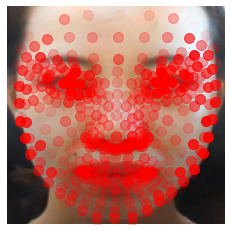

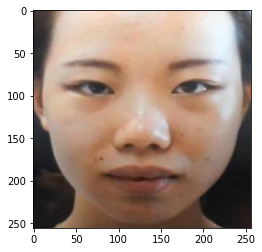

In [105]:
explain_with_intergrade(test_loader,"/media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_18_HR_4/cropped_0075.jpg")

In [104]:
explain_with_grad_cam(test_loader,"/media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_18_HR_4/cropped_0075.jpg")

Epoch 1:   0%|                                     | 0/22296 [00:00<?, ?batch/s]

/media/hassan-hossein/B660FEE360FEA8EF/casia-ds/preposess/casia_test_spoof_18_HR_4/cropped_0075.jpg.pt
tensor([[1.0187e-25]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[ 1.3938e-28, -3.3653e-29,  6.4550e-28,  ...,  1.6143e-28,
          1.1267e-28,  4.5729e-29],
        [ 2.7835e-28, -4.3860e-28, -4.8313e-30,  ...,  8.7635e-29,
          1.4323e-28, -8.5503e-29],
        [ 4.4246e-28, -2.8920e-28,  1.5980e-28,  ...,  1.5677e-28,
          2.2735e-28, -2.5897e-29],
        ...,
        [ 2.1450e-28, -2.9934e-28, -1.1962e-27,  ..., -6.8839e-29,
          4.0417e-28, -5.5297e-28],
        [ 2.0768e-28, -1.7541e-28,  2.5667e-28,  ...,  3.2957e-28,
          3.0801e-28, -1.2819e-28],
        [ 1.7848e-28, -2.3150e-28,  1.3460e-28,  ...,  8.3651e-29,
          3.5699e-28, -2.3989e-29]], device='cuda:0')
Min value: 0.0, Max value: 0.0
Max scaled value before rescaling: 0.0


ZeroDivisionError: float division by zero